# ResNet Ablation Study

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## cats_vs_dogs dataset

In [2]:
# dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [4]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
ds_info.features['label'].num_classes

2

In [7]:
ds_info.features['label'].names

['cat', 'dog']

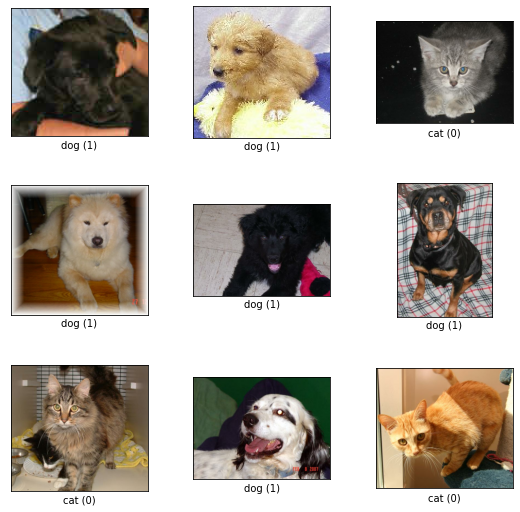

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

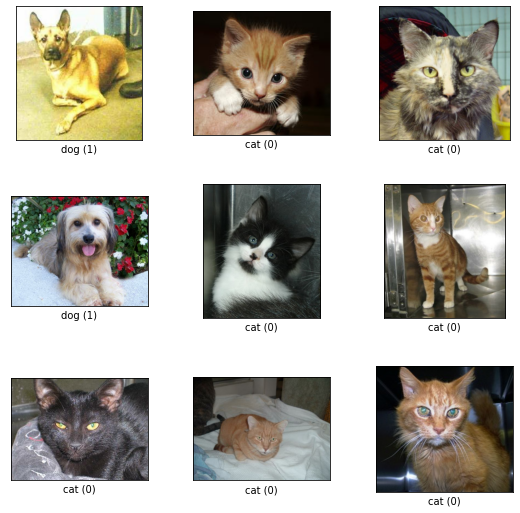

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

## ResNet block build

In [10]:
def build_resnet_residual(x, channel, kernel_size=3, stride=1, conv_shortcut=False, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x     
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(filters=channel, kernel_size=3, strides=2, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [11]:
def build_resnet_bottleneck(x, channel, kernel_size=3, stride=1, conv_shortcut=False, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel * 4, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 1, strides=1, padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)
    
    x1 = layers.Conv2D(channel * 4, 1, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [12]:
def build_resnet_blocks(input_layer, 
                        num_cnn=3, 
                        channel=64, 
                        strides=1,
                        block_num=0, 
                        is_plain=False, 
                        is_50=False):
    # input layer
    x = input_layer
    if is_50:
        for i in range(num_cnn):
            if block_num == 2 and i == 0:
                x = build_resnet_bottleneck(x, channel, conv_shortcut=True, is_plain=is_plain)
            elif block_num != 2 and i == 0:
                x = build_resnet_bottleneck(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:
                x = build_resnet_bottleneck(x, channel, is_plain=is_plain)
    else:
        for i in range(num_cnn):
            if block_num != 2 and i == 0:
                x = build_resnet_residual(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:
                x = build_resnet_residual(x, channel, is_plain=is_plain)
        
    return x

In [13]:
def build_resnet(input_shape=(224, 224, 3), 
                 num_cnn_list=[3, 4, 6, 3], 
                 channel_list=[64, 128, 256, 512], 
                 num_classes=10, 
                 is_plain=False, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = layers.Input(shape=input_shape)
    output = input_layer
    
    # conv1
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', name='conv1')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    output = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same', name='conv2_maxpool2d')(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_blocks(output, 
                                    num_cnn=num_cnn, 
                                    channel=channel, 
                                    block_num=i+2,
                                    is_plain=is_plain,
                                    is_50=is_50)
        
    output = keras.layers.GlobalAveragePooling2D(name='average_pooling')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

# ResNet 34 Residual Model

In [14]:
resnet34_residual = build_resnet(input_shape=(224, 224, 3), num_classes=2)

In [15]:
resnet34_residual.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
tf.keras.utils.plot_model(resnet34_residual, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# ResNet 34 Plain Model

In [17]:
resnet34_plain = build_resnet(input_shape=(224, 224, 3), is_plain=True, num_classes=2)

In [18]:
resnet34_plain.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_36 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_33 (ReLU)              (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_maxpool2d (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_37 (Batc (None, 56, 56, 64)        256 

In [19]:
tf.keras.utils.plot_model(resnet34_plain, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Train

In [20]:
BATCH_SIZE = 32
EPOCH = 50
# cats_vs_dogs dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
# ResNet34-Plain
resnet34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 47s 64ms/step - loss: 0.6985 - accuracy: 0.5405 - val_loss: 0.7008 - val_accuracy: 0.5143
Epoch 2/50
581/581 [==============================] - 35s 61ms/step - loss: 0.6896 - accuracy: 0.5506 - val_loss: 0.9836 - val_accuracy: 0.5195
Epoch 3/50
581/581 [==============================] - 35s 61ms/step - loss: 0.6745 - accuracy: 0.5844 - val_loss: 1.5679 - val_accuracy: 0.5319
Epoch 4/50
581/581 [==============================] - 35s 61ms/step - loss: 0.6651 - accuracy: 0.6004 - val_loss: 0.7472 - val_accuracy: 0.5310
Epoch 5/50
581/581 [==============================] - 35s 61ms/step - loss: 0.6533 - accuracy: 0.6230 - val_loss: 1.4460 - val_accuracy: 0.5196
Epoch 6/50
581/581 [==============================] - 36s 61ms/step - loss: 0.6437 - accuracy: 0.6262 - val_loss: 0.6918 - val_accuracy: 0.5429
Epoch 7/50
581/581 [==============================] - 35s 61ms/step - loss: 0.6302 - accuracy: 0.6362 - val_loss: 0.6523 - val_accuracy:

In [22]:
# ResNet34-Residual
resnet34_residual.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_residual = resnet34_residual.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 42s 63ms/step - loss: 0.6529 - accuracy: 0.6217 - val_loss: 0.6621 - val_accuracy: 0.6196
Epoch 2/50
581/581 [==============================] - 37s 64ms/step - loss: 0.6011 - accuracy: 0.6729 - val_loss: 0.6253 - val_accuracy: 0.6711
Epoch 3/50
581/581 [==============================] - 37s 63ms/step - loss: 0.5473 - accuracy: 0.7193 - val_loss: 0.7097 - val_accuracy: 0.6153
Epoch 4/50
581/581 [==============================] - 37s 63ms/step - loss: 0.5101 - accuracy: 0.7457 - val_loss: 0.5851 - val_accuracy: 0.7181
Epoch 5/50
581/581 [==============================] - 36s 63ms/step - loss: 0.4549 - accuracy: 0.7853 - val_loss: 0.6766 - val_accuracy: 0.6889
Epoch 6/50
581/581 [==============================] - 37s 63ms/step - loss: 0.3923 - accuracy: 0.8226 - val_loss: 0.5109 - val_accuracy: 0.7698
Epoch 7/50
581/581 [==============================] - 37s 63ms/step - loss: 0.3312 - accuracy: 0.8554 - val_loss: 0.5046 - val_accuracy:

# Layer 34의 Plain, Residual 비교 결과
- training loss 의 경우에는 residual이 더 빠르게 수렴되는 것을 볼 수 있다
- validation accuracy의 경우는 residual이 초반에 확 올라가지만 결과적으로는 plain이 높은 것을 확인할 수 있다.

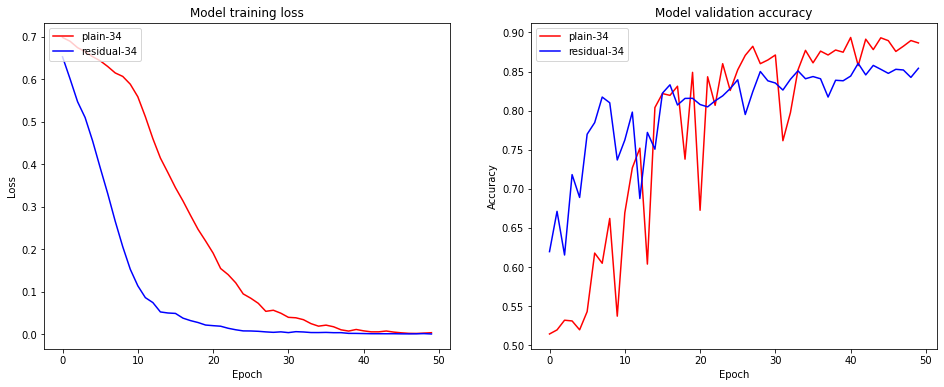

In [23]:
# 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_34_plain.history['loss'], 'r')
plt.plot(history_34_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain-34', 'residual-34'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_plain.history['val_accuracy'], 'r')
plt.plot(history_34_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain-34', 'residual-34'], loc='upper left')
plt.show()

# ResNet 50 Residual Model

In [24]:
resnet50_residual = build_resnet(input_shape=(224, 224, 3), is_50=True, num_classes=2)

In [25]:
resnet50_residual.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu_66 (ReLU)                 (None, 112, 112, 64) 0           batch_normalization_72[0][0]     
____________________________________________________________________________________________

In [26]:
tf.keras.utils.plot_model(resnet50_residual, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# ResNet 50 Plain Model

In [27]:
resnet50_plain = build_resnet(input_shape=(224, 224, 3), is_plain=True, is_50=True, num_classes=2)

In [28]:
resnet50_plain.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_125 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_115 (ReLU)             (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_maxpool2d (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_127 (Bat (None, 56, 56, 64)        256 

In [29]:
tf.keras.utils.plot_model(resnet50_plain, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Train

In [30]:
# ResNet50-Plain
resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 58s 87ms/step - loss: 0.7084 - accuracy: 0.5326 - val_loss: 0.7411 - val_accuracy: 0.5713
Epoch 2/50
581/581 [==============================] - 51s 87ms/step - loss: 0.7050 - accuracy: 0.5319 - val_loss: 0.7918 - val_accuracy: 0.5197
Epoch 3/50
581/581 [==============================] - 50s 87ms/step - loss: 0.7056 - accuracy: 0.5229 - val_loss: 1.6116 - val_accuracy: 0.5139
Epoch 4/50
581/581 [==============================] - 51s 88ms/step - loss: 0.7023 - accuracy: 0.5241 - val_loss: 0.9554 - val_accuracy: 0.5072
Epoch 5/50
581/581 [==============================] - 51s 87ms/step - loss: 0.7046 - accuracy: 0.5153 - val_loss: 0.7341 - val_accuracy: 0.5125
Epoch 6/50
581/581 [==============================] - 51s 87ms/step - loss: 0.6993 - accuracy: 0.5251 - val_loss: 0.7492 - val_accuracy: 0.5392
Epoch 7/50
581/581 [==============================] - 51s 87ms/step - loss: 0.6947 - accuracy: 0.5418 - val_loss: 0.8847 - val_accuracy:

In [31]:
# ResNet50-Residual
resnet50_residual.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_residual = resnet50_residual.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 67s 103ms/step - loss: 0.7096 - accuracy: 0.5676 - val_loss: 0.7751 - val_accuracy: 0.5333
Epoch 2/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6878 - accuracy: 0.5953 - val_loss: 1.1689 - val_accuracy: 0.5297
Epoch 3/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6674 - accuracy: 0.6176 - val_loss: 0.6830 - val_accuracy: 0.5760
Epoch 4/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6551 - accuracy: 0.6293 - val_loss: 0.7791 - val_accuracy: 0.5781
Epoch 5/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6517 - accuracy: 0.6346 - val_loss: 0.9070 - val_accuracy: 0.5312
Epoch 6/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6373 - accuracy: 0.6489 - val_loss: 0.6636 - val_accuracy: 0.6328
Epoch 7/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6294 - accuracy: 0.6543 - val_loss: 0.6619 - val_ac

# Layer 50의 Plain, Residual 비교 결과
- training loss 의 경우에는 residual이 더 빠르게 수렴되는 것을 볼 수 있다. 34와는 다르게 residual이 훨씬 낮은것을 확인할 수 있다.
- validation accuracy의 경우는 residual이 28 에폭까지는 plain보다 높지만  이 후부터는 plain이 급격하게 상승해서 높게 유지하는 것을 확인할 수 있다.

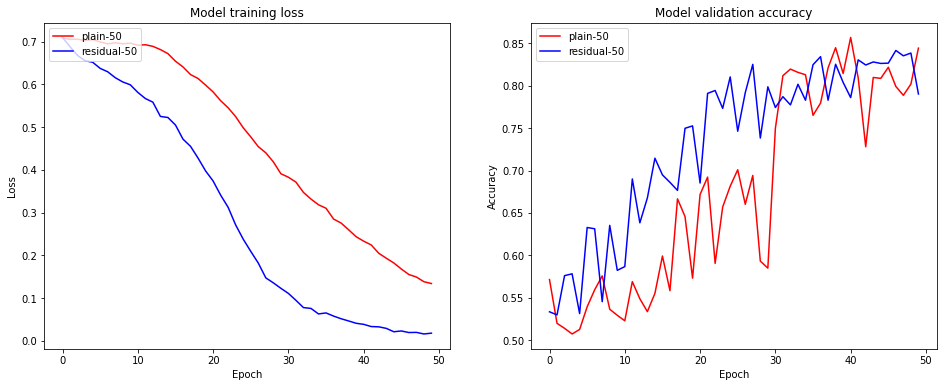

In [32]:
# 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_50_plain.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain-50', 'residual-50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_50_plain.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain-50', 'residual-50'], loc='upper left')
plt.show()

# ResNet 34 와 50의 비교
- 논문과는 다르게 ResNet 34가 더 빠르게 수렴했으며, 정확도도 높았다.
- 논문과 epoch수와 optimizer가 다른 것이 원인이라고 생각된다. 

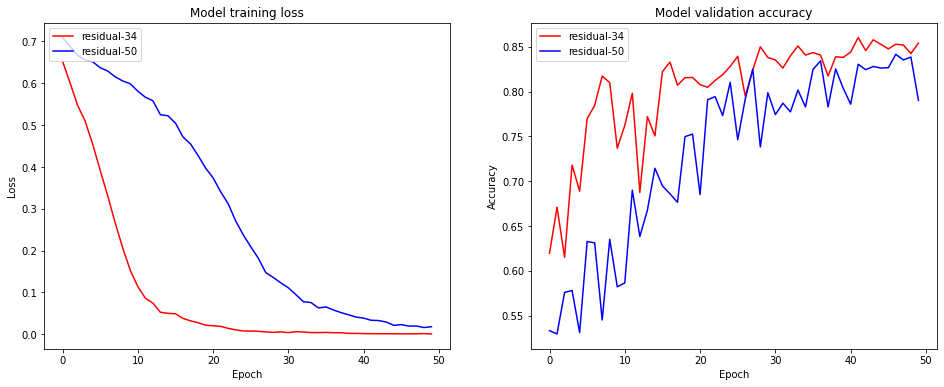

In [33]:
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_34_residual.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['residual-34', 'residual-50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_residual.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['residual-34', 'residual-50'], loc='upper left')
plt.show()

# Tensorflow 내장 ResNet50 Model

In [34]:
resnet50 = tf.keras.applications.ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), classes=2)

In [35]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [36]:
tf.keras.utils.plot_model(resnet50, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [37]:
# ResNet50-Residual
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 67s 103ms/step - loss: 0.7036 - accuracy: 0.5706 - val_loss: 0.9740 - val_accuracy: 0.4805
Epoch 2/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6756 - accuracy: 0.6075 - val_loss: 0.7596 - val_accuracy: 0.5750
Epoch 3/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6713 - accuracy: 0.6098 - val_loss: 0.7472 - val_accuracy: 0.5621
Epoch 4/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6588 - accuracy: 0.6262 - val_loss: 0.8741 - val_accuracy: 0.5820
Epoch 5/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6525 - accuracy: 0.6344 - val_loss: 0.6939 - val_accuracy: 0.5972
Epoch 6/50
581/581 [==============================] - 60s 103ms/step - loss: 0.6484 - accuracy: 0.6329 - val_loss: 0.9573 - val_accuracy: 0.5608
Epoch 7/50
581/581 [==============================] - 61s 104ms/step - loss: 0.6423 - accuracy: 0.6398 - val_loss: 0.7111 - val_ac

# 내장 모델 비교
- 직접 구현한 ResNet50과 내장 모델의 결과와 일치하는 것을 확인할 수 있다.

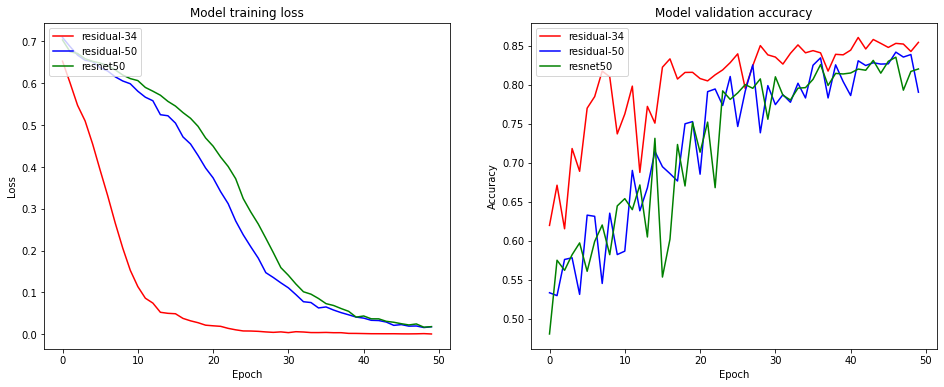

In [38]:
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_34_residual.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'g')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['residual-34', 'residual-50', 'resnet50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_residual.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['residual-34', 'residual-50', 'resnet50'], loc='upper left')
plt.show()

## 회고록
- 다른 노드에 비해서 목적이 명확해서 하기가 좀 수월했다. 
- 학교에서 논문을 보고 구현하는 것을 해봐서 그런지 생각보다 어려운 느낌은 없었다. 
- 고잉디퍼 노드중에서 가장 무난하게 진행했던 노드였다. 다만 block단위로 만드는게 좀 복잡했던..
- 이제 고잉디퍼도 거의 막바지를 향해 달려가고 있다. 끝까지 화이팅